In [1]:
import io
import math
import gzip
import nltk
import time
import random
import numpy as np
import tensorflow as tf
import gensim.downloader as api
import tensorflow_datasets as tfds

from collections import Counter
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import skipgrams

In [2]:
import zipfile

def load_data():
    with zipfile.ZipFile('C:\\Users\\pelevinmd\\Downloads\\text8.zip', 'r') as zip_ref:
        with zip_ref.open('text8', 'r') as file:
            file_content = file.read()
    wiki = file_content.decode()
    return wiki

wiki = load_data()

In [3]:
def get_drop_prob(x, threshold_value):
  return 1 - np.sqrt(threshold_value/x)

def subsample_words(words, word_counts):
  threshold_value = 1e-5
  total_count = len(words)
  freq_words = {word: (word_counts[word]/total_count) for word in set(words)}
  subsampled_words = [word for word in words if random.random() < (1 - get_drop_prob(freq_words[word], threshold_value))]
  return subsampled_words

def preprocess_text(text):
  # Replace punctuation with tokens so we can use them in our model
  text = text.lower()
  text = text.strip()
  text = text.replace('.', ' <PERIOD> ')
  text = text.replace(',', ' <COMMA> ')
  text = text.replace('"', ' <QUOTATION_MARK> ')
  text = text.replace(';', ' <SEMICOLON> ')
  text = text.replace('!', ' <EXCLAMATION_MARK> ')
  text = text.replace('?', ' <QUESTION_MARK> ')
  text = text.replace('(', ' <LEFT_PAREN> ')
  text = text.replace(')', ' <RIGHT_PAREN> ')
  text = text.replace('--', ' <HYPHENS> ')
  text = text.replace('?', ' <QUESTION_MARK> ')
  text = text.replace(':', ' <COLON> ')
  words = text.split()

  # Remove stopwords
  stopwords_eng = set(stopwords.words('english'))
  words = [word for word in words if word not in stopwords_eng]
  # Remove all the words with frequency less than 5
  word_counts = Counter(words)
  print("Count of words: %s" % (len(words)))
  filtered_words = [word for word in words if word_counts[word] >= 5]
  print("Count of filtered words: %s" % (len(filtered_words)))
  # Subsample words with threshold of 10^-5
  subsampled_words = subsample_words(filtered_words, word_counts)
  print("Count of subsampled words: %s" % (len(subsampled_words)))

  return word_counts, subsampled_words

word_counts, preprocessed_words = preprocess_text(wiki[:5000000])

Count of words: 535524
Count of filtered words: 480253
Count of subsampled words: 127281


In [5]:
preprocessed_words[1500:1550]

['useful',
 'aide',
 'directions',
 'time',
 'explain',
 'child',
 'aide',
 'normal',
 'extra',
 'help',
 'techniques',
 'assist',
 'teacher',
 'familiar',
 'child',
 'disorder',
 'every',
 'students',
 'autism',
 'levels',
 'school',
 'student',
 'exhibits',
 'explosive',
 'recognize',
 'preparing',
 'lower',
 'teaching',
 'social',
 'systematic',
 'teaching',
 'approaches',
 'incredible',
 'five',
 'behavioral',
 'strategies',
 'increase',
 'excessive',
 'dsm',
 'section',
 'manual',
 'qualitative',
 'impairment',
 'manifested',
 'least',
 'impairment',
 'behaviors',
 'eye',
 'eye',
 'facial']

In [6]:
EMBEDDING_DIM = 128
BUFFER_SIZE = 1024
BATCH_SIZE = 64
EPOCHS = 5

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(preprocessed_words)
VOCAB_SIZE = len(tokenizer.word_counts)
vectorized_words = [tokenizer.word_index[word] for word in preprocessed_words]

pairs, labels = skipgrams(vectorized_words, VOCAB_SIZE, window_size=3, negative_samples=1.0, shuffle=True)
target_words = [p[0] for p in pairs]
context_words = [q[1] for q in pairs]

SAMPLE_SIZE = len(labels)
labels_sample = labels[:SAMPLE_SIZE]
target_words_sample = target_words[:SAMPLE_SIZE]
context_words_sample = context_words[:SAMPLE_SIZE]
train_size = int(len(labels_sample) * 0.9)
train_target_words, train_context_words, train_labels = target_words_sample[:train_size], context_words_sample[:train_size], labels_sample[:train_size]
test_target_words, test_context_words, test_labels = target_words_sample[train_size:], context_words_sample[train_size:], labels_sample[train_size:]

train_dataset = tf.data.Dataset.from_tensor_slices((train_target_words, train_context_words, train_labels)).shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((test_target_words, test_context_words, test_labels)).shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [8]:
print("# (train, test) batches: " + str(len(list(train_dataset.as_numpy_iterator()))) + ", " + str(len(list(test_dataset.as_numpy_iterator()))))

# (train, test) batches: 21478, 2386


In [9]:
class SkipGramModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim):
      super(SkipGramModel, self).__init__()
      self.shared_embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=1, name='word_embeddings')
      self.flatten = tf.keras.layers.Flatten(name='flatten')
      self.dense1 = tf.keras.layers.Dense(64, activation=tf.nn.relu, name='dense_one')
      self.dropout1 = tf.keras.layers.Dropout(0.2, name = 'dropout1')
      self.dense2 = tf.keras.layers.Dense(32, activation=tf.nn.relu, name='dense_two')
      self.dropout2 = tf.keras.layers.Dropout(0.2, name = 'dropout2')
      self.pred = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid, name='predictions')

    def call(self, target_word, context_word, training=True):
      x = self.shared_embedding(target_word)
      y = self.shared_embedding(context_word)
      x = self.flatten(x)
      y = self.flatten(y)
      shared = tf.multiply(x, y)
      dense_output1 = self.dense1(shared)
      if training: dense_output1 = self.dropout1(dense_output1)
      dense_output2 = self.dense2(dense_output1)
      if training: dense_output2 = self.dropout2(dense_output2)
      output = self.pred(dense_output2)
      return tf.reshape(output, [-1])

model = SkipGramModel(VOCAB_SIZE+1, EMBEDDING_DIM)

In [10]:
optimiser = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.BinaryCrossentropy()
train_acc_metric = tf.keras.metrics.BinaryAccuracy()
val_acc_metric = tf.keras.metrics.BinaryAccuracy()

In [11]:
@tf.function
def train_step(target_words, context_words, labels):
    with tf.GradientTape() as tape:
      preds = model(target_words, context_words)
      loss = loss_fn(labels, preds)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimiser.apply_gradients(zip(gradients, model.trainable_variables))
    train_acc_metric.update_state(labels, preds)
    return loss

@tf.function
def test_step(target_words, context_words, labels):
    preds = model(target_words, context_words, training=False)
    loss = loss_fn(labels, preds)
    val_acc_metric.update_state(labels, preds)
    return loss

for epoch in range(EPOCHS):
  start_time = time.time()
  print("Starting epoch: %d " % (epoch,))
  cumm_loss = 0
  for step, (target_words, context_words, labels) in enumerate(train_dataset):
    train_loss = train_step(target_words, context_words, labels)
    cumm_loss += train_loss
  train_acc = train_acc_metric.result()
  print("Training acc over epoch: %.4f" % (float(train_acc),))
  train_acc_metric.reset_states()
  print("Cummulative loss: %.4f " % (cumm_loss,))

  test_cumm_loss = 0
  for step, (target_words, context_words, labels) in enumerate(test_dataset):
    test_loss = test_step(target_words, context_words, labels)
    test_cumm_loss += test_loss
  val_acc = val_acc_metric.result()
  print("Validation acc over epoch: %.4f" % (float(val_acc),))
  val_acc_metric.reset_states()
  print("Cummulative test loss: %f " % (test_cumm_loss,))
  print("Time taken: %.2fs" % (time.time() - start_time))

Starting epoch: 0 
Training acc over epoch: 0.6383
Cummulative loss: 13185.2109 
Validation acc over epoch: 0.7407
Cummulative test loss: 1245.053101 
Time taken: 675.53s
Starting epoch: 1 
Training acc over epoch: 0.8615
Cummulative loss: 7069.0674 
Validation acc over epoch: 0.8150
Cummulative test loss: 1079.709351 
Time taken: 666.43s
Starting epoch: 2 
Training acc over epoch: 0.9384
Cummulative loss: 3615.8313 
Validation acc over epoch: 0.8436
Cummulative test loss: 1133.389893 
Time taken: 676.49s
Starting epoch: 3 
Training acc over epoch: 0.9660
Cummulative loss: 2200.5264 
Validation acc over epoch: 0.8574
Cummulative test loss: 1184.167969 
Time taken: 668.50s
Starting epoch: 4 
Training acc over epoch: 0.9771
Cummulative loss: 1572.6125 
Validation acc over epoch: 0.8633
Cummulative test loss: 1195.816406 
Time taken: 615.64s


In [12]:
# Save weights to a Tensorflow Checkpoint file
model.save_weights('./skip_gram_weights_wiki_5000000')

In [13]:
word_embeddings_layer = model.layers[0]
weights = word_embeddings_layer.get_weights()[0]
print("Word Embeddings shape: %s" % (weights.shape,))

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in tokenizer.index_word.items():
  vec = weights[num] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

Word Embeddings shape: (12378, 128)


In [14]:
weights

array([[-1.6981363e-04,  4.5179371e-02,  4.8954833e-02, ...,
        -3.6300719e-02,  4.8676383e-02, -1.0427415e-02],
       [ 5.5380833e-01,  3.9888835e-03, -1.9100678e-01, ...,
         5.9408797e-03,  5.8744484e-01,  2.8295997e-01],
       [ 5.4423172e-02,  1.8154179e-01,  2.8425637e-01, ...,
         3.3884647e-01,  8.1990741e-02,  6.0413492e-01],
       ...,
       [-2.9256573e-01, -1.9695251e-01,  1.8637660e-01, ...,
         5.1240806e-02, -1.9593951e-01,  1.1679285e-01],
       [ 2.4994560e-01, -4.4999504e-01,  1.3954513e-01, ...,
         5.8502609e-01,  4.3746474e-01, -1.2471072e-01],
       [ 4.7464386e-01, -9.6701190e-02,  2.9856208e-01, ...,
        -3.3276165e-01, -2.5007907e-01,  1.2695716e-01]], dtype=float32)

In [15]:
viz_words = 500

In [16]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=1, n_iter=15000, metric='cosine')
embs=tsne.fit_transform(weights)

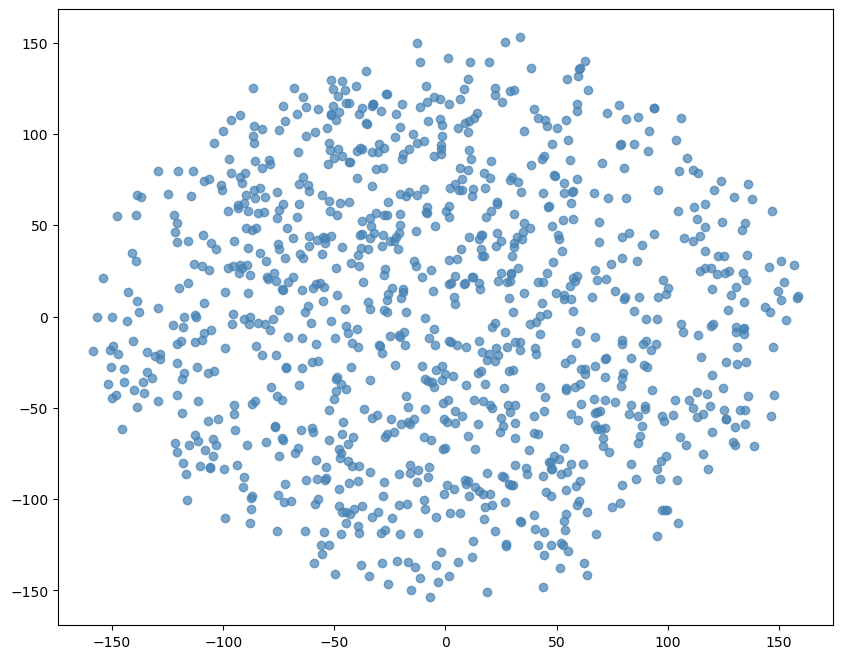

In [17]:
import matplotlib.pyplot as plt
FS = (10, 8)
fig,ax=plt.subplots(figsize=FS)
for _ in range(1000):
    plt.scatter(*embs[_,:],color='steelblue',alpha=.7)